# Impact of the geometry on HPL performance

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
import re
warnings.simplefilter(action='ignore')

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_platform(archive_name):
    info = get_yaml(archive_name, 'info.yaml')
    expfiles = info['expfile']
    platform = [f for f in expfiles if f.endswith('xml')]
    assert len(platform) == 1
    return platform[0]

def read_csv(archive_name, file_name):
    archive = zipfile.ZipFile(archive_name)
    res = pandas.read_csv(io.BytesIO(archive.read(file_name)))
    res['filename'] = archive_name
    return res

def read_result(name):
    res = read_csv(name, 'results.csv')
    res['start_timestamp'] = pandas.to_datetime(res['start_timestamp'])
    res['start'] = res['start_timestamp'] - res['start_timestamp'].min()
    return res

def read_sim_result(name):
    archive = zipfile.ZipFile(name)
    result = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    result['platform'] = get_platform(name)
    result['filename'] = name
    info = get_yaml(name, 'info.yaml')
    expfiles = info['expfile']
    dgemm_file = [f for f in expfiles if f.endswith('.yaml')]
    assert len(dgemm_file) == 1
    result['dgemm_file'] = dgemm_file[0]
    reg = re.compile('dgemm_synthetic(_shrinked(-[0-9]+)?)?_(?P<platform_id>[0-9]+).yaml')
    match = reg.fullmatch(dgemm_file[0])
    if match is not None:
        result['platform_id'] = 'A' + match.groupdict()['platform_id']
    else:
        reg = re.compile('dgemm_synthetic(_shrinked(-[0-9]+)?)?_spatial_[0-9]*(\.[0-9]*)?_id-(?P<platform_id>[0-9]+).yaml')
        match = reg.fullmatch(dgemm_file[0])
        assert match is not None
        result['platform_id'] = 'B' + match.groupdict()['platform_id']
    dgemm_model = get_yaml(name, dgemm_file[0])
    synthetic = 'experiment_date' not in dgemm_model['info']
    result['synthetic'] = synthetic
    try:
        nb_removed_nodes = dgemm_model['info']['nb_removed_nodes']
    except KeyError:
        nb_removed_nodes = 0
    result['nb_removed_nodes'] = nb_removed_nodes
    sum_gflops = sum(2e-9/node['mnk'] for node in dgemm_model['model'])
    min_gflops = min(2e-9/node['mnk'] for node in dgemm_model['model'])
    result['theoretical_peak'] = sum_gflops
    result['theoretical_smart_peak'] = min_gflops*dgemm_model['info']['nb_nodes']
    return result

simulation_dir = ['geometry/7/']
simulation_files = [os.path.join(simdir, f) for simdir in simulation_dir for f in os.listdir(simdir) if f.endswith('.zip')]

df = pandas.concat([read_sim_result(f) for f in simulation_files])
df['nb_nodes'] = df['proc_p'] * df['proc_q']
df['geometry'] = df['proc_p'].astype(str) + '×' + df['proc_q'].astype(str)
df.head()

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,...,platform,filename,dgemm_file,platform_id,synthetic,nb_removed_nodes,theoretical_peak,theoretical_smart_peak,nb_nodes,geometry
0,300000,512,12,25,1,2,2,1,0,8,...,dahu_synthetic_large.xml,geometry/7/grenoble_2020-06-24_1937288.zip,dgemm_synthetic_3.yaml,A3,True,0,213409.462069,200206.830862,300,12×25
1,100000,512,12,25,1,2,2,1,0,8,...,dahu_synthetic_large.xml,geometry/7/grenoble_2020-06-24_1937288.zip,dgemm_synthetic_3.yaml,A3,True,0,213409.462069,200206.830862,300,12×25
2,200000,512,12,25,1,2,2,1,0,8,...,dahu_synthetic_large.xml,geometry/7/grenoble_2020-06-24_1937288.zip,dgemm_synthetic_3.yaml,A3,True,0,213409.462069,200206.830862,300,12×25
0,300000,512,2,150,1,2,2,1,0,8,...,dahu_synthetic_large.xml,geometry/7/grenoble_2020-06-24_1937282.zip,dgemm_synthetic_2.yaml,A2,True,0,211632.433023,197752.970080,300,2×150
1,100000,512,2,150,1,2,2,1,0,8,...,dahu_synthetic_large.xml,geometry/7/grenoble_2020-06-24_1937282.zip,dgemm_synthetic_2.yaml,A2,True,0,211632.433023,197752.970080,300,2×150


### Checking the parameters

In [2]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'heterogeneous_dgemm', 'platform', 'model', 'filename',
                   'simulation', 'slow_nodes',
                   'major_page_fault', 'minor_page_fault', 'matrix_size', 'mode',
                   'start_timestamp', 'stop_timestamp', 'dgemm_file', 'platform_id',
                  'theoretical_peak', 'theoretical_smart_peak'}
colnames = set(df) - name_exceptions
df.groupby(list(colnames))[['swap']].count()

swap
block_size depth thread_per_process swap geometry proc_p process_per_node nb_removed_nodes synthetic bcast rfact nb_nodes mem_align proc_q pfact      
512        1     32                 0    10×30    10     1                0                True      2     2     300      8         30     1        12
                                         12×25    12     1                0                True      2     2     300      8         25     1        12
                                         15×20    15     1                0                True      2     2     300      8         20     1        12
                                         2×150    2      1                0                True      2     2     300      8         150    1        12
                                         3×100    3      1                0                True      2     2     300      8         100    1        12
                                         4×75     4      1                0                True      2     2     300      8         75     1        12
                                         5×60     5      1                0                True      2     2     300      8         60     1        12
                                         6×50     6      1                0                True      2     2     300      8         50     1        12

## HPL performance

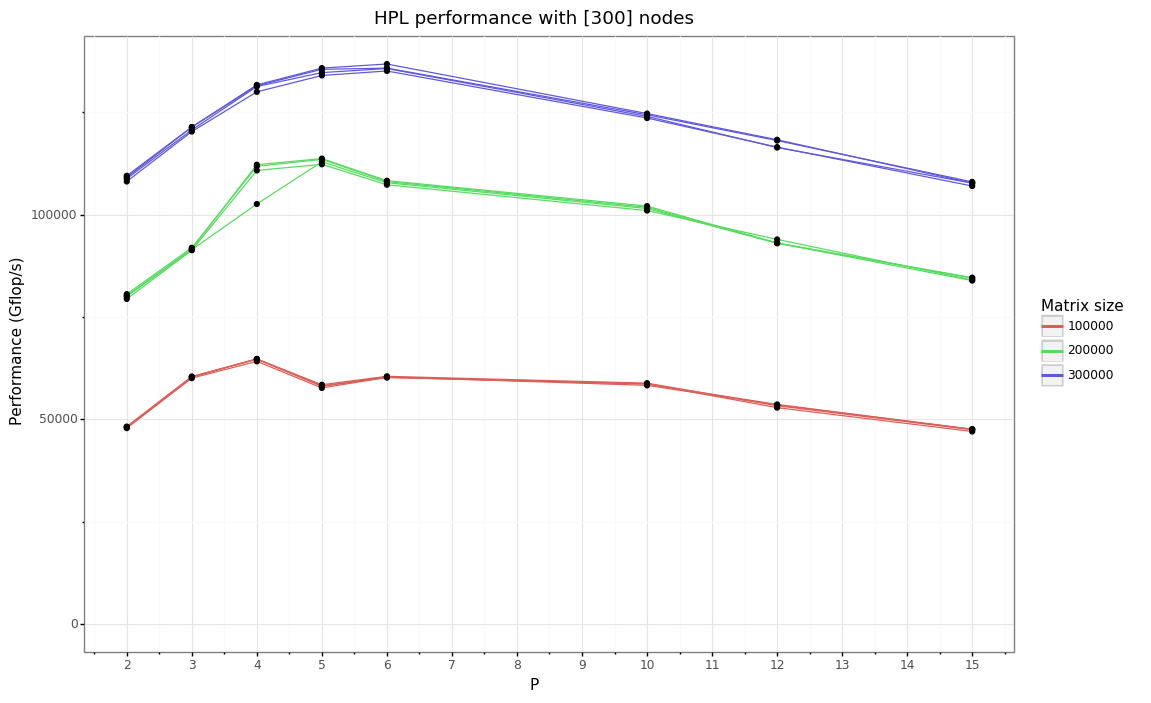

<ggplot: (8733251364861)>

In [3]:
df['group'] = df['dgemm_file'] + ':' + df['matrix_size'].astype(str)
(ggplot(df)
    + aes(x='proc_p', y='gflops', color='factor(matrix_size)', group='group')
#    + geom_text(aes(label='geometry'), position=position_nudge(y=200))
    + geom_line()
    + geom_point(color="black")
    + theme_bw()
    + labs(x='P', y='Performance (Gflop/s)', color='Matrix size')
    + expand_limits(y=0)
    + scale_x_continuous(breaks=range(df['proc_p'].min(), df['proc_p'].max()+1))
    + ggtitle(f'HPL performance with {df["nb_nodes"].unique()} nodes')
)